# Restless DRAG Calibrations using a restless `DataProcessor`

In this tutorial we demonstrate how we can perform a *restless* DRAG calibration with qiskit-experiments.

**What is a restless experiment?**

Usually, when running circuits on a quantum device, the qubit is reset to the ground state after each measurement to ensure a well-defined initial state for the next circuit. This can be done passively by waiting several $T_1$-times such that the qubit decays due to the interaction with the environment if it was in the excited state. Since the $T_1$-times are continuously being increased (already beyond $100 \mu s$), this initialization procedure becomes time-consuming and inefficient. 
Another more efficient way is to actively reset the qubit - and this is how a qubit is reset on the IBM Quantum devices. This saves time but also lasts a few microseconds.  

However, for several types of experiments, a reset is not needed and we can directly continue with the following circuit after a small delay time, even if the qubit was measured in the excited state. This is the idea of a restless measurement. This tutorial shows that we can perform a restless DRAG calibration which can lead to a reduced experiment duration.

In [1]:
import numpy as np

from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

backend = provider.get_backend('ibmq_bogota')

The IBM Quantum devices have dynamical repetition delays anabled. This means that we can choose the delay after a circuit in a range of delays, typically 0 to 500$\mu$s. The default value is for most of the devices 250$\mu$s. Our aim will be to set this delay to a small value of 1$\mu$s.

In [2]:
config = backend.configuration()
defaults = backend.defaults()

print('Rep. delay range:', config.rep_delay_range)
print('Default rep. delay:', config.default_rep_delay)

Default rep. delay: 0.00025
Rep. delay range: [0.0, 0.0005]


## 1. Standard DRAG Calibration experiment

In [4]:
from qiskit_experiments.library.calibration.drag import DragCal
from qiskit_experiments.calibration_management.update_library import Drag

In [4]:
qubit = 2

cal_drag = DragCal(qubit)

cal_drag.set_experiment_options(betas=np.linspace(-10, 10, 25), reps=[3, 5, 7])

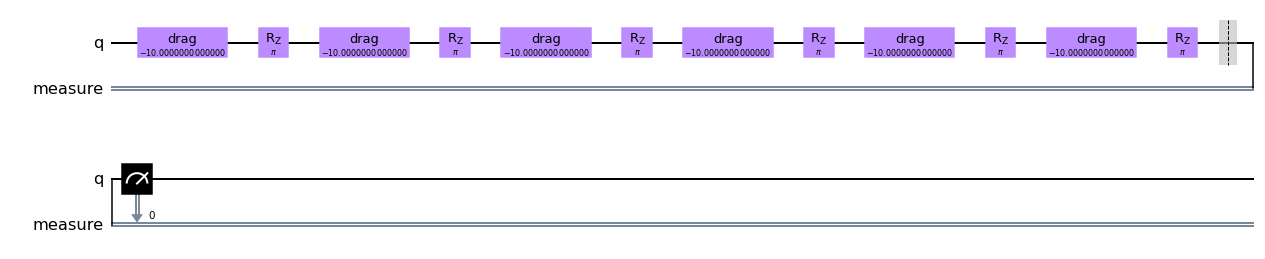

In [5]:
cal_drag.circuits()[0].draw(output='mpl')

In [6]:
drag_data = cal_drag.run(backend)
drag_data.block_for_results()

<ExperimentData[DragCal], backend: ibmq_jakarta, status: DONE, experiment_id: a6e4b439-656b-4fdc-8e7b-80b279e85fd3>

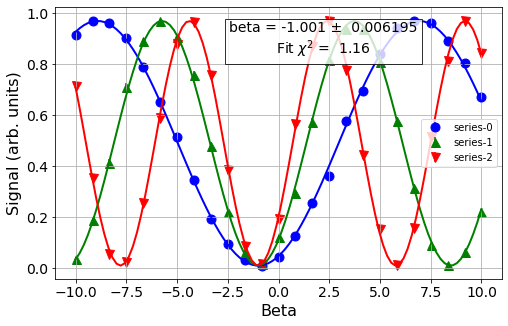

In [7]:
drag_data.figure(0)

In [8]:
print(drag_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -1.0005884013631083 ± 0.006194782805461188
- χ²: 1.1595489293957502
- quality: good
- device_components: ['Q2']
- verified: False


## 2. Restless DRAG Calibration experiment

In [3]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import RestlessToCounts, Probability

### We need the following settings to perform a restless DRAG Calibration experiment:

Set the run options:
1. Set the `rep_delay` to a small value, e.g. $1 \mu s$
2. Ensure that the qubit is not initialized in the ground state throughout the experiment: `init_qubits=False`

This means that now the circuits are executed without reseting the qubit after a measurement. The following circuit is run after a small delay time.

### 2.1. Try a restless DRAG calibration with a standard analysis

In [17]:
restless_cal_drag_no_processor = DragCal(qubit)

restless_cal_drag_no_processor.set_experiment_options(betas=np.linspace(-10, 10, 25), reps=[3, 5, 7])

# set restless run options
restless_cal_drag_no_processor.set_run_options(rep_delay=1e-6, meas_level=2, memory=True, init_qubits=False)

In [18]:
restless_drag_no_processor_data = restless_cal_drag_no_processor.run(backend)
restless_drag_no_processor_data.block_for_results()

<ExperimentData[DragCal], backend: ibmq_jakarta, status: DONE, experiment_id: b4dd0b81-148c-430d-9222-ff92e69973dd>

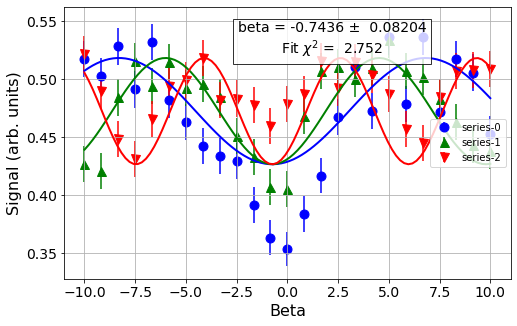

In [19]:
restless_drag_no_processor_data.figure(0)

In [20]:
print(restless_drag_no_processor_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -0.7435846738701113 ± 0.08204421971610394
- χ²: 2.7520590736043773
- quality: good
- device_components: ['Q2']
- verified: False


### We need post-process the restless data!

### 2.2. Restless DRAG calibration experiment with a restless data processor

Define the `restless_processor`:

3. Specify a `DataProcessor` that uses the `RestlessToCounts` node

### How does this restless `DataProcessor` work?

All single counts are classified: If the measurement outcome of circuit n is the same as the outcome of circuit n-1, we label the outcome of circuit n as a "1" and if they differ, as a "0". This data is then further analysed by running the standard DRAG calibration analysis. 

In [21]:
restless_cal_drag = DragCal(qubit)

restless_cal_drag.set_experiment_options(betas=np.linspace(-10, 10, 25), reps=[3, 5, 7])

# set restless run options
restless_cal_drag.set_run_options(rep_delay=1e-6, meas_level=2, memory=True, init_qubits=False)

# restless data processor
restless_processor = DataProcessor("memory", [RestlessToCounts(header={"memory_slots": 1}), Probability("1")])
restless_cal_drag.set_analysis_options(data_processor=restless_processor)

In [22]:
restless_drag_data = restless_cal_drag.run(backend)
restless_drag_data.block_for_results()

<ExperimentData[DragCal], backend: ibmq_jakarta, status: DONE, experiment_id: 84a12a6a-486a-454d-b5a9-f35b1ea04481>

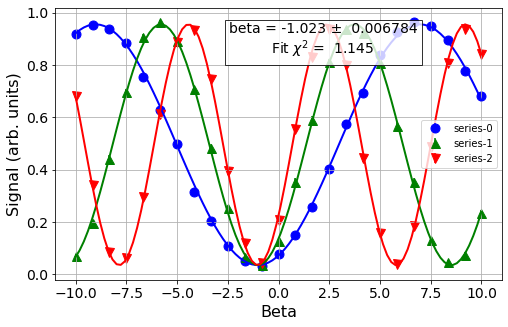

In [23]:
restless_drag_data.figure(0)

In [24]:
print(restless_drag_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -1.0234959452702959 ± 0.006783552420789714
- χ²: 1.1451206905672038
- quality: good
- device_components: ['Q2']
- verified: False


## 3. Compare the results and job runtimes

Results of the experiments:

**Standard DRAG calibration**: $\beta = -1.001 \pm 0.006$

**Restless DRAG calibration**: $\beta = -1.023 \pm 0.007$

In [29]:
job = backend.retrieve_job(drag_data.job_ids[0])
job_restless = backend.retrieve_job(restless_drag_data.job_ids[0])
print(f'Job duration for standard DRAG calibration: {job.result().time_taken}s')
print(f'Job duration for restless DRAG calibration: {job_restless.result().time_taken}s')

Job duration for standard DRAG calibration: 26.472450494766235s
Job duration for restless DRAG calibration: 5.066109895706177s


### We observe a significant job duration reduction!

Note that `job.result().time_taken` does not only contain the circuit execution time but also, e.g. loading the job.

## 4. Restless Randomnized Benchmarking

In [4]:
from qiskit_experiments.library import StandardRB
from qiskit_experiments.library.randomized_benchmarking import RBAnalysis

In [5]:
lengths = np.arange(1, 1200, 100)
num_samples = 10
seed = 1010
qubits = [3]

In [6]:
restless_processor = DataProcessor("memory", [RestlessToCounts(header={"memory_slots": 1}), Probability("1")])

# Run a restless RB experiment on qubit 2
rb_exp_restless = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
rb_exp_restless.set_run_options(rep_delay=1e-6, meas_level=2, memory=True, init_qubits=False)
rb_exp_restless.set_analysis_options(data_processor=restless_processor, return_data_points=True)

In [7]:
expdata_restless = rb_exp_restless.run(backend)

In [9]:
expdata_restless

<ExperimentData[StandardRB], backend: ibmq_bogota, status: DONE, experiment_id: 619ce386-edf8-4cce-96df-349852534ba4>

In [13]:
expdata_restless.analysis_results(1)

DbAnalysisResultV1(name=alpha, value=FitVal(value=0.9988406985017518, stderr=0.00021242144816043776, unit=None), device_components=[<Qubit(Q3)>], experiment_id=619ce386-edf8-4cce-96df-349852534ba4, result_id=5c0507d8-edb8-43ce-9d58-b6c515c1317d, chisq=0.04802418275299727, quality=None, verified=False, extra={}, tags=[], service='619ce386-edf8-4cce-96df-349852534ba4')

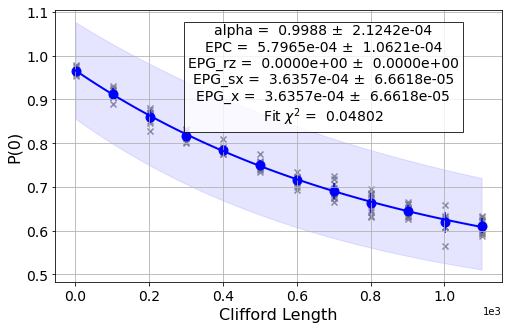

In [12]:
expdata_restless.figure(0)